# Part 2: Catchment Area and Subbasins

In this part we will define the catchment area for Cologne. We will limit ourselves to the Rhine basin and further narrow the region to the parts upstream to Cologne to only work with geographical areas that we expect to contribute to the water discharge in Cologne.

We also want to have some spatial resolution by using subbasins, instead of full catchment area. For example if rainfalls to Alps but not to other parts, taking full average on the whole area will make the significance of rainfall in Alps disappear. We also now for example weather in Moselle will impact Moselle river mostly, so having some regional sub-categories make also sense.

#### Datasets
- E-OBS: https://surfobs.climate.copernicus.eu/dataaccess/access_eobs_chunks.php
- Rhine Basin geomaps: https://www.hydrosheds.org/products/hydrobasins#downloads

<div style="display:flex; justify-content:center; gap:20px;">
  <figure style="text-align:center;">
    <img src="images/rheincatchment.jpg" 
         alt="Rhine catchment" 
         width="400" 
         style="border:2px solid black;">
    <figcaption style="font-style:italic; color:gray; margin-top:5px;">
      Figure 2a. Basin of river Rhein © WWasser / CC-BY-SA-4.0
    </figcaption>
  </figure>

  <figure style="text-align:center;">
    <img src="images/subbasins.png" 
         alt="Sub-basins of Rhine" 
         width="425" 
         style="border:2px solid black;">
    <figcaption style="font-style:italic; color:gray; margin-top:5px;">
      Figure 2b. Sub-basins of the Rhein
    </figcaption>
  </figure>
</div>


## Cologne Catchment Area

In [1]:
# Read-in the water level dataset and check the content
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
INF_str = "/Users/oncel/Documents/Projects/KoelnPegelML/data/"


In [2]:
%matplotlib inline

import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Read-in the netCDF file
INFILE_base = "/Users/oncel/Documents/Projects/KoelnPegelML/data/"
INFILE_rr = "/Users/oncel/Documents/Projects/KoelnPegelML/data/rr_ens_mean_0.1deg_reg_2011-2024_v31.0e.nc"


In [3]:
shapefile = INFILE_base + "/hybas_eu_lev08_v1c/hybas_eu_lev08_v1c.shp"
print(shapefile)
import regionmask
import geopandas as gpd
basins = gpd.read_file(shapefile)

# --- 2. Cologne coordinates ---
cologne_point = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy([6.96], [50.94]),  # lon, lat
    crs=basins.crs
)

/Users/oncel/Documents/Projects/KoelnPegelML/data//hybas_eu_lev08_v1c/hybas_eu_lev08_v1c.shp


In [4]:
print(basins)

         HYBAS_ID   NEXT_DOWN   NEXT_SINK    MAIN_BAS  DIST_SINK  DIST_MAIN  \
0      2080000010           0  2080000010  2080000010        0.0        0.0   
1      2080000020           0  2080000020  2080000020        0.0        0.0   
2      2080821360  2080000020  2080000020  2080000020       55.1       55.1   
3      2080821500  2080000020  2080000020  2080000020       55.1       55.1   
4      2080825220  2080821500  2080000020  2080000020       76.7       76.7   
...           ...         ...         ...         ...        ...        ...   
25310  2080109350           0  2080109350  2080109350        0.0        0.0   
25311  2080109520           0  2080109520  2080109520        0.0        0.0   
25312  2080109860  2080411370  2080109860  2080023010        0.0      381.2   
25313  2080110090           0  2080110090  2080110090        0.0        0.0   
25314  2080111540           0  2080111540  2080111540        0.0        0.0   

       SUB_AREA  UP_AREA   PFAF_ID  ENDO  COAST  OR

In [5]:
# Find basin that contains Cologne
cologne_basin = basins[basins.contains(cologne_point.iloc[0].geometry)]
cologne_id = cologne_basin.iloc[0]["HYBAS_ID"]
print("Cologne HYBAS_ID:", cologne_id)

Cologne HYBAS_ID: 2080399810


In [6]:
# Recursive upstream search function
def get_upstream_ids(basins, target_id):
    """Return all HYBAS_IDs upstream of a given catchment."""
    upstream_ids = set()
    queue = [target_id]
    
    while queue:
        current = queue.pop()
        # Find all basins flowing into this one
        ups = basins[basins["NEXT_DOWN"] == current]["HYBAS_ID"].tolist()
        for u in ups:
            if u not in upstream_ids:
                upstream_ids.add(u)
                queue.append(u)
    return upstream_ids

In [7]:
# Get upstream catchments for Cologne
upstream_ids = get_upstream_ids(basins, cologne_id)

# Include Cologne itself
upstream_basins = basins[basins["HYBAS_ID"].isin(upstream_ids) | (basins["HYBAS_ID"] == cologne_id)]
print("Number of upstream sub-catchments:", len(upstream_basins))

# Merge into a single polygon
cologne_catchment = upstream_basins.dissolve(by="NEXT_SINK")  # dissolve into one basin

# Save for future
upstream_basins.to_file("Cologne_upstream_subbasins.shp")
cologne_catchment.to_file("Cologne_upstream_catchment.shp")

Number of upstream sub-catchments: 259


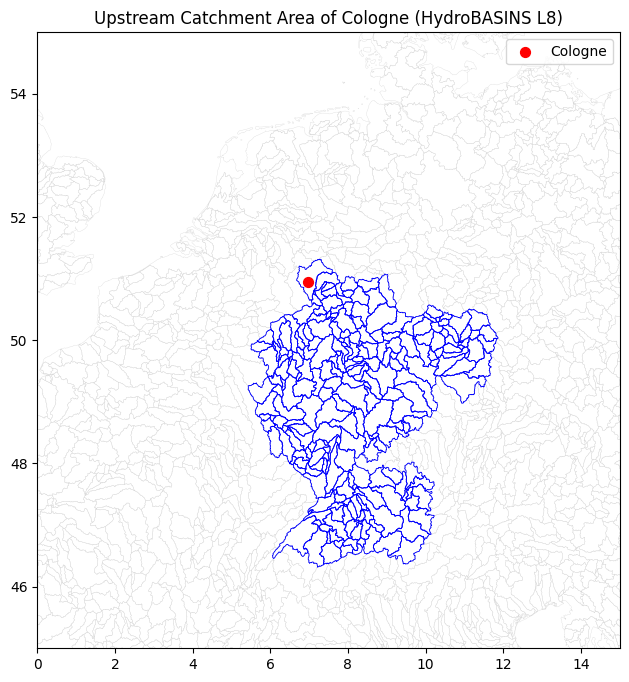

In [8]:
# Plot the area
fig, ax = plt.subplots(figsize=(8,8))
basins.boundary.plot(ax=ax, color="lightgray", linewidth=0.2)
upstream_basins.boundary.plot(ax=ax, color="blue", linewidth=0.6)
cologne_point.plot(ax=ax, color="red", markersize=50, label="Cologne")
ax.set_xlim(0, 15)
ax.set_ylim(45, 55)
plt.title("Upstream Catchment Area of Cologne (HydroBASINS L8)")
plt.legend()
plt.show()

## Study the subbasins

Cologne HYBAS_ID: 2080399810
Number of upstream sub-basins: 259
        HYBAS_ID  SUB_AREA   PFAF_ID
6336  2080399810    2002.1  23261070
6345  2080411180      18.7  23261081
6346  2080411370     243.7  23261091
6347  2080410160     283.5  23261083
6348  2080409990     827.4  23261082


<Axes: >

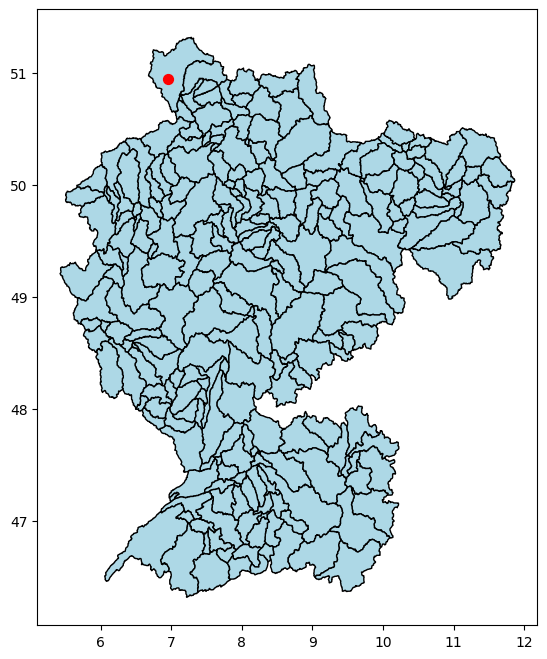

In [9]:
import geopandas as gpd
from shapely.geometry import Point

# Load HydroBASINS Level 8 shapefile
basins = gpd.read_file(INF_str+"/hybas_eu_lev08_v1c/hybas_eu_lev08_v1c.shp")


# Cologne coordinates
cologne_point = Point(6.96, 50.94)  # lon, lat

# Find which sub-basin contains Cologne
cologne_basin = basins[basins.contains(cologne_point)].iloc[0]
cologne_id = cologne_basin["HYBAS_ID"]

print("Cologne HYBAS_ID:", cologne_id)

# Trace upstream sub-basins
# HydroBASINS stores downstream connections in NEXT_DOWN
upstream_ids = set()
to_check = [cologne_id]

while to_check:
    current = to_check.pop()
    upstream_ids.add(current)

    # find all basins that flow into current
    upstream = basins[basins["NEXT_DOWN"] == current]["HYBAS_ID"].tolist()
    for uid in upstream:
        if uid not in upstream_ids:
            to_check.append(uid)

# Extract GeoDataFrame of upstream basins
upstream_basins = basins[basins["HYBAS_ID"].isin(upstream_ids)]

print(f"Number of upstream sub-basins: {len(upstream_basins)}")
print(upstream_basins[["HYBAS_ID","SUB_AREA","PFAF_ID"]].head())

# Plot
ax = upstream_basins.plot(edgecolor="black", facecolor="lightblue", figsize=(8,8))
gpd.GeoSeries([cologne_point], crs="EPSG:4326").plot(ax=ax, color="red", markersize=50)


There are simply too many subbasins on this level. Making one input variable for each subbasin would create thousands of input variables, which is not feasible and very useful. Let's try to find a more coarse subbasin set by looking at level 5

In [10]:
# Level 5
basins_lvl5 = gpd.read_file(INFILE_base + "/hybas_eu_lev05_v1c/hybas_eu_lev05_v1c.shp").to_crs("EPSG:4326")

# Keep only those inside Cologne catchment
basins_lvl5_in_cologne = gpd.overlay(basins_lvl5, cologne_catchment, how="intersection")
print(basins_lvl5.columns)

Index(['HYBAS_ID', 'NEXT_DOWN', 'NEXT_SINK', 'MAIN_BAS', 'DIST_SINK',
       'DIST_MAIN', 'SUB_AREA', 'UP_AREA', 'PFAF_ID', 'ENDO', 'COAST', 'ORDER',
       'SORT', 'geometry'],
      dtype='object')


In [11]:
# Define output path
out_shp = "cologne_subbasins_lvl5.shp"

# Save GeoDataFrame to shapefile
basins_lvl5_in_cologne.to_file(out_shp, driver="ESRI Shapefile")

print(f"Saved {len(basins_lvl5_in_cologne)} subbasins to {out_shp}")

Saved 12 subbasins to cologne_subbasins_lvl5.shp


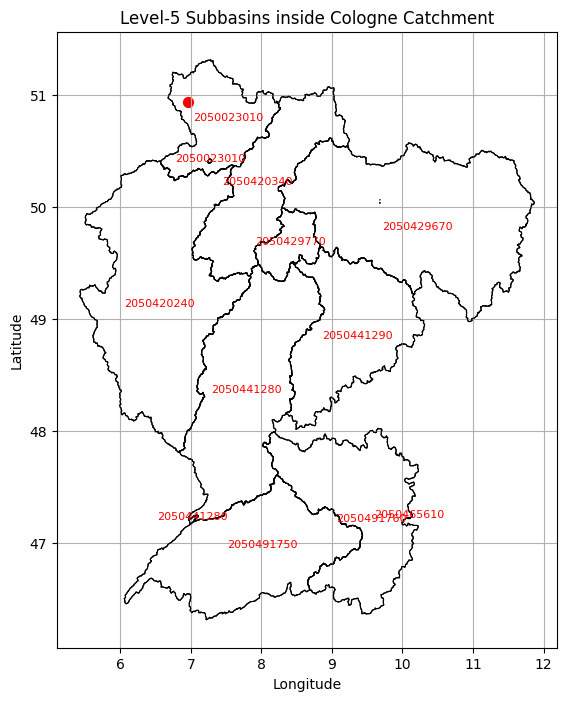

In [12]:
#Subset RR data to bounding box for efficiency
lon_min, lat_min, lon_max, lat_max = basins_lvl5_in_cologne.total_bounds

fig, ax = plt.subplots(figsize=(8,8))

# Plot subbasins
basins_lvl5_in_cologne.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.8)

# Plot boundaries
basins_lvl5_in_cologne.boundary.plot(ax=ax, edgecolor="black", linewidth=0.8)

# Annotate with HYBAS_ID
for idx, row in basins_lvl5_in_cologne.iterrows():
    centroid = row.geometry.representative_point()  # safer than centroid for labels
    ax.annotate(
        text=str(row["HYBAS_ID_1"]),
        xy=(centroid.x, centroid.y),
        ha="center",
        fontsize=8,
        color="red"
    )
gpd.GeoSeries([cologne_point], crs="EPSG:4326").plot(ax=ax, color="red", markersize=50)
plt.title("Level-5 Subbasins inside Cologne Catchment")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

Level 5 seems like a good compromise between granularity of having different regions and still not having too many by being too specific. The subbasins here also overlap with the map at the beginning, except here there seem to be some very small subbasins that doesn't appear on the illustrated plot.

## Adding info to the training dataset

In [13]:
print(basins_lvl5_in_cologne.columns.tolist())

['HYBAS_ID_1', 'NEXT_DOWN_1', 'NEXT_SINK', 'MAIN_BAS_1', 'DIST_SINK_1', 'DIST_MAIN_1', 'SUB_AREA_1', 'UP_AREA_1', 'PFAF_ID_1', 'ENDO_1', 'COAST_1', 'ORDER_1', 'SORT_1', 'HYBAS_ID_2', 'NEXT_DOWN_2', 'MAIN_BAS_2', 'DIST_SINK_2', 'DIST_MAIN_2', 'SUB_AREA_2', 'UP_AREA_2', 'PFAF_ID_2', 'ENDO_2', 'COAST_2', 'ORDER_2', 'SORT_2', 'geometry']


In [14]:
subareas = basins_lvl5_in_cologne[["HYBAS_ID_1", "SUB_AREA_1"]]

# Convert to dictionary for easy mapping later
area_dict = dict(zip(subareas["HYBAS_ID_1"], subareas["SUB_AREA_1"]))

print(subareas)

    HYBAS_ID_1  SUB_AREA_1
0   2050465610     50388.9
1   2050023010     25335.7
2   2050023010     25335.7
3   2050420240     28101.2
4   2050420340     11589.0
5   2050429670     27404.6
6   2050429770      2780.0
7   2050441280     20549.5
8   2050441280     20549.5
9   2050441290     13946.2
10  2050491750     17568.6
11  2050491760     15847.8


In [15]:
for area in subareas:
    print(area)

HYBAS_ID_1
SUB_AREA_1


In [16]:
# Read-in the dataset to be expanded
df_train_pegel = pd.read_csv("training_datasets/train_pegels_precip_humd_snow_preprocessed.csv", index_col=0, parse_dates=True)

In [17]:
# Sort to keep consistent order
subareas = subareas.sort_index()

# Create DataFrame with repeated values for each date in df_all
df_subareas = pd.DataFrame(
    np.tile(subareas["SUB_AREA_1"].values, (len(df_train_pegel), 1)),
    index=df_train_pegel.index,
    columns=[f"sbs_area_{i}" for i in range(len(subareas))]
)

# Merge with your training DataFrame
df_all_extended = pd.concat([df_train_pegel, df_subareas], axis=1)

In [18]:
df_all_extended

,Kln_h,Fra_h,Fra_diff,Ruw_h,Ruw_diff,Klk_h,Klk_diff,Rhw_h,Rhw_diff,Kau_h,...,sbs_area_2,sbs_area_3,sbs_area_4,sbs_area_5,sbs_area_6,sbs_area_7,sbs_area_8,sbs_area_9,sbs_area_10,sbs_area_11
2000-01-02,599.583333,185.875000,-9.907609,388.468750,-27.313859,289.833333,-13.003623,162.687500,-1.008152,401.260417,...,25335.7,28101.2,11589.0,27404.6,2780.0,20549.5,20549.5,13946.2,17568.6,15847.8
2000-01-03,554.885417,185.854167,-0.020833,361.312500,-27.156250,281.895833,-7.937500,164.416667,1.729167,367.989583,...,25335.7,28101.2,11589.0,27404.6,2780.0,20549.5,20549.5,13946.2,17568.6,15847.8
2000-01-04,517.239583,181.718750,-4.135417,341.687500,-19.625000,276.354167,-5.541667,165.333333,0.916667,346.093750,...,25335.7,28101.2,11589.0,27404.6,2780.0,20549.5,20549.5,13946.2,17568.6,15847.8
2000-01-05,495.114583,179.125000,-2.593750,340.864583,-0.822917,308.843750,32.489583,165.770833,0.437500,327.968750,...,25335.7,28101.2,11589.0,27404.6,2780.0,20549.5,20549.5,13946.2,17568.6,15847.8
2000-01-06,480.500000,180.947917,1.822917,324.427083,-16.437500,320.489583,11.645833,165.343750,-0.427083,311.135417,...,25335.7,28101.2,11589.0,27404.6,2780.0,20549.5,20549.5,13946.2,17568.6,15847.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,526.739583,179.333333,-7.343750,307.072917,-60.072917,289.385417,-32.187500,208.593750,-17.395833,384.572917,...,25335.7,28101.2,11589.0,27404.6,2780.0,20549.5,20549.5,13946.2,17568.6,15847.8
2018-12-28,492.197917,171.187500,-8.145833,272.541667,-34.531250,259.239583,-30.145833,205.052083,-3.541667,339.822917,...,25335.7,28101.2,11589.0,27404.6,2780.0,20549.5,20549.5,13946.2,17568.6,15847.8
2018-12-29,427.062500,164.239583,-6.947917,264.197917,-8.343750,239.822917,-19.416667,205.010417,-0.041667,287.895833,...,25335.7,28101.2,11589.0,27404.6,2780.0,20549.5,20549.5,13946.2,17568.6,15847.8
2018-12-30,377.739583,165.072917,0.833333,254.479167,-9.718750,229.302083,-10.520833,205.145833,0.135417,249.947917,...,25335.7,28101.2,11589.0,27404.6,2780.0,20549.5,20549.5,13946.2,17568.6,15847.8


In [19]:
# Save expanded dataset
df_all_extended.to_csv("training_datasets/train_pegels_precip_humd_snow_area_preprocessed.csv", index=True) 